# Intro

The aim of this notebook is to use density based clustering (DBSCAN) to identify accident hotspots in Hamburg for the year 2016. DBSCAN groups points that are closely packed together and marks points outside of these groups as noise. Therefore, using this algorithm, locations in which a high density of accidents take place will be highlighted as clusters. We can then plot the location of these clusters using folium. First we need to load in the data:

In [1]:
import numpy as np 
import pandas as pd 
import folium
from folium.plugins import HeatMap
from geopy.distance import great_circle
from sklearn.cluster import DBSCAN as dbscan
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Define a function to generate base map

In [2]:
def generateBaseMap(default_location=[53.540086,9.967263], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [3]:
df = pd.read_csv('acc2016hamburg.csv', usecols = ['Latitude','Longitude','No.involved','Hour','Year'])
df

,Year,Hour,No.involved,Longitude,Latitude
0,2016,16,2,9.853808,53.598265
1,2016,12,1,9.852056,53.598460
2,2016,18,2,9.853749,53.598346
3,2016,19,2,10.145766,53.678078
4,2016,12,1,10.168288,53.534661
...,...,...,...,...,...
7206,2016,11,2,9.978172,53.458331
7207,2016,8,3,10.134735,53.670281
7208,2016,7,1,9.908848,53.610363
7209,2016,14,2,10.014119,53.518401


#Check the types of variables...lat/long should be float not string

In [ ]:
df.dtypes

#first, copy all data to our map dataframe

In [4]:
df_map = df.copy()
df_map['count']=1
df_map[['Latitude', 'Longitude', 'count']].groupby(['Latitude', 'Longitude']).sum().sort_values('count', ascending=False).head(10)

,,count
Latitude,Longitude,
53.518486,10.015559,3
53.582338,10.067752,3
53.601760,9.994112,2
53.586051,9.967585,2
53.487154,10.218335,2
53.538868,10.127324,2
53.558894,10.025903,2
53.595070,9.924131,2
53.600940,9.889113,2


Generate a base map and then heat map

In [5]:
base_map = generateBaseMap()
base_map
m = HeatMap(data=df_map[['Latitude', 'Longitude', 'count']].groupby(['Latitude','Longitude']).sum().reset_index().values.tolist(), radius=7, max_zoom=10).add_to(base_map)
m.save('accident_heatmap.html')

DBSCAN requires a metric to use when calculating the distance between points. To do this we shall create a function that takes the latitude and longitude of two points and calculates the distance between them in meters. The great_circle function from geopy is used to ensure that the curvature of the Earth is taken into account when calculating these distances. 

In [6]:
def greatcircle(x,y):
    lat1, long1 = x[0], x[1]
    lat2, long2 = y[0], y[1]
    dist = great_circle((lat1,long1),(lat2,long2)).meters
    return dist

Now we can find the clusters. The eps parameter determines the maximum distance between two samples for one to be considered as in the neighborhood of the other. This and the min_samples parameter can be adjusted to change the size and number of points contained in each cluster. Points not located within clusters are given the label -1.

In [10]:
eps = 100 #distance in meters
min_samples = 10

df_dbc = df

loc = df_dbc[['Latitude','Longitude']]

dbc = dbscan(eps = eps, min_samples = min_samples, metric=greatcircle).fit(loc)

labels = dbc.labels_
unique_labels = np.unique(dbc.labels_)

print(unique_labels)

df_dbc['Cluster'] = labels

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58]


Now that we have found the clusters we can plot them on a map using folium. We can assign colours to each cluster so that they can be more easily identified.

In [12]:
location = df_dbc['Latitude'].mean(), df_dbc['Longitude'].mean()

m = folium.Map(location=location,zoom_start=13)

folium.TileLayer('cartodbpositron').add_to(m)

clust_colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

for i in range(0,len(df_dbc)):
    colouridx = df_dbc['Cluster'].iloc[i]
    if colouridx == -1:
        pass
    else:
        col = clust_colours[colouridx%len(clust_colours)]
        folium.CircleMarker([df_dbc['Latitude'].iloc[i],df_dbc['Longitude'].iloc[i]], radius = 10, color = col, fill = col).add_to(m)
m.save('accident_spatialclusters.html')

We have found the spacial clusters, but what if we want to find the regions *and* times that accidents are most likely to occur?  To achieve this we need to perform spaciotemporal clustering. This was done by creating a new distance metric that takes both space and time into account:

In [7]:
# here we first set the limits for the distances used in space and time for clustering
spatial_dist_max = 500 # meters
temporal_dist_max = 5 # hours

def GreatCircle(lat1,long1,lat2,long2):
    dist = great_circle((lat1,long1),(lat2,long2)).meters
    return dist

def SpaceTimeDistance(x,y):
    diff_days = math.fabs(x[2] - y[2])
    if (np.isnan(diff_days) or diff_days > temporal_dist_max):
        return np.Infinity
    
    try:
        gc_dist = GreatCircle(x[1],x[0],y[1],y[0])
    except ValueError:
        #print(x[1],x[0],y[1],y[0])
        gc_dist = np.Infinity
    
    if (gc_dist>spatial_dist_max):
        return np.Infinity
    
    ratio_t=diff_days/temporal_dist_max
    ratio_d=gc_dist/spatial_dist_max
    if (ratio_d>ratio_t):
        return gc_dist
    else:
        return ratio_t * spatial_dist_max


Use this metric to determine the clusters:

In [14]:
eps = 100
min_no_samples = 5

clustered = dbscan(eps = eps, metric=SpaceTimeDistance, min_samples=min_no_samples).fit(df[['Latitude','Longitude','Hour']])
labels=clustered.labels_
unique_labels=np.unique(clustered.labels_)

df_sptc = df
df_sptc['Cluster'] = labels

print(unique_labels)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


Once again we can plot these clusters onto a map using folium. In this case I thought it would be interesting to colour the clusters according to the number of vehicles involved in the accident.

In [15]:
df_sptc['colour'] = df['No.involved']

df_sptc.loc[df_sptc['No.involved'] == 1, 'colour'] = '#ff7f00' #orange
df_sptc.loc[df_sptc['No.involved'] == 2, 'colour'] = '#1f78b4' #blue
df_sptc.loc[df_sptc['No.involved'] == 3, 'colour'] = '#b2df8a' #green
df_sptc.loc[df_sptc['No.involved'] == 4, 'colour'] = '#e31a1c' #red

location = df_sptc['Latitude'].mean(), df_sptc['Longitude'].mean()
m = folium.Map(location=location,zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(m)

for i in range(0,len(df_sptc)): 
    if df_sptc['Cluster'].iloc[i] == -1:
        pass
    else:
        col = df_sptc['colour'].iloc[i]
        folium.CircleMarker([df_sptc['Latitude'].iloc[i],df_sptc['Longitude'].iloc[i]], radius = 10, color = col, fill = col).add_to(m)

m.save('accident_prediction.html')

This shows that accidents involving two or more vehicles are more likely to take place at busy junctions such as those near bridges. Conversly, accidents involving one vehicle are generally found in areas containing large numbers of pedestrians such as Rothenbaumchaussee Street.

We can try and visualise the hours in which these accidents take place using a space-time cube:

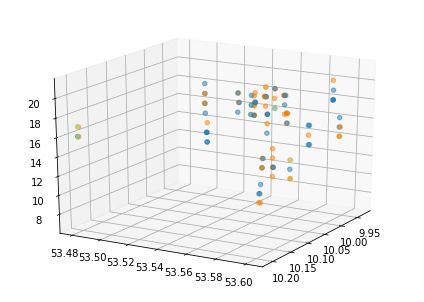

In [16]:
plotpoint_colour = 'colour'

fig = plt.figure(1)
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=30) # change parameters here for experimenting

df_sptc_nn = df_sptc[df_sptc['Cluster'] != -1] # remove noise
ax.scatter(df_sptc_nn['Longitude'], df_sptc_nn['Latitude'], df_sptc_nn['Hour'], c = df_sptc_nn[plotpoint_colour], alpha=0.5)

plt.show()

This representation is fairly confusing but it does provide a general idea of the cluster locations in spacetime. 

